# Introduction to Dataset 

The dataset consists of 10 000 data points stored as rows with 14 features in columns
UID: unique identifier ranging from 1 to 10000
product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. 
tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes
tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail 

# **1. Business Understanding**

#### 1.1 **Determine the type of failure**

# **2 Data Understanding**

#### **2.1 Import the libraries used in the project**

In [1134]:
# Data wrangling
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Off FutureWarnings
import warnings
warnings.filterwarnings('ignore')

#Resampling
from imblearn.over_sampling import SMOTENC
from sklearn.utils import class_weight

#Dimension Reduction
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

# Save model
import pickle


#### **2.2 Upload DataFrame as df**

In [1096]:
## Upload df
df = pd.read_csv(r'C:\Users\eng.fitness69\Documents\predictive_maintenance\predictive_maintenance.csv')
pd.options.mode.chained_assignment = None
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


#### **2.3 Check if exist duplicate values**

In [1097]:
# Verify if the data has duplicate values
data_duplicates = df.duplicated().sum()
print("Total duplicated values ", data_duplicates)

Total duplicated values  0


**There are not duplicate values, so we don't need remove any row.**

#### **2.4 Check if exist missing values**

In [1098]:
# Verify if the data has missing values
data_null = df.isnull().sum().sum()
print("Total missing values: ", data_null)

Total missing values:  0


**There are not missing values, so we don't need apply some strategic to deal with this, like SimpleImputer that deal with numeric and categoric columns.**

#### **2.5 Verify the data structure**

In [1099]:
## Verify the data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


**As we saw in the last sub topic we can confirm here that there aren't null values in the columns and that the their type is correct.**

#### **2.6 Describe numeric features**

In [1100]:
## Numeric features analysis
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


**As possible see that the columns "Rotational speed", "Torque" and "Tool wear" may have outliers values. So we'll analyse better this in the next steps and conclude if there are outiliers and as to proceed with this values.**

#### **2.7 Verify "Target" column distribution**

In [1101]:
## Verify the proportion of column "Target"
df.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

**As is possible see, the dataset has unbalanced classes in this columns, 95% of this dataset is classified without failure. In the next steps will be necessary analyse as proceed with this.**

#### **2.8 Verify "Failure Type" distribution**

In [1102]:
## Verify the proportion of column "Failure_type"
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

**As can be see, we dont have proportion in the column "Failure_type" distribution, because of that will be necessary apply any strategic to deal with this to previne the model to has overfitting or that any random palpite to classify the failure class perform better than any model like DummyClassifier.**

# **3. Data Preparation**


#### **3.1 Rename the columns**

**This step is not necessary but to be easier manipulate the columns i prefer.**

In [1103]:
rename_columns = {
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'    
}

df.rename(rename_columns, axis = 1, inplace = True)

#### **3.2 Identify redundance rows**

In [1104]:
# Analysing redundance value, count failures on "Target" column
count_failures = (df['Target'] == 1).sum()
print('Number of failures:', count_failures)

# Sum of occurrences of 'Failure_type' other than 'No Failure'
sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Sum of failures different of "No Failure":', sum_failures)

Number of failures: 339
Sum of failures different of "No Failure": 330


**As we can see there are 9 ambiguos values, so we need remove this.**

#### **3.3 Remove redundance rows**

In [1105]:
# Filter the rows with has 1 in the column "Target" and 'No Failure' in the column 'Failure_type'
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]

# Remove this filtered row in the main df
df.drop(rows_to_remove.index, inplace=True)

#### **3.4 Remove columns unnecessary**

**As would mencioned in the topic 1 (Business Understanding), our objetive is classify the type of failure, so we don't need the "Target" columns, because always that the column "Failure_type" is different of "No Failure" the "Target" will be 1 and 0 when is "No Failure. Furthermore, the columnds "ID" and "Product_ID" is only unique id's, so we dont need this too**

In [1106]:
#Removing unnecessary columnds
drop_columns = ["ID", "Product_ID", "Target"]
df.drop(drop_columns, axis = 1, inplace = True)

#### **3.5 Remove "Random Failures"**

**We dont have a significant quantity of this class to try predict when it happen, so if we dont remove this now, we can have problems relacioned a big imbalanced classes. As us objetive is classfy the type of failure and apply the concepts of data science, i will remove this.**

In [1107]:
# Removing "Random Failures" of the "Failure_type" column.
df = df.loc[df['Failure_type'] != 'Random Failures']

#### **3.6 Rename classes of "Type" column**

**I prefer rename the categories L, M and H of "Type" column to be more cleareful what each one represents.**

In [1108]:
## Renaming the classes
rename_type = {
    'L':'Low',
    'M':'Medium',
    'H':'High'
}

df['Type'].replace(rename_type, inplace = True)

#### **3.7 Plot "Type" distribution**

**To be more clearful see this distribution lets plot a bar graphic.**

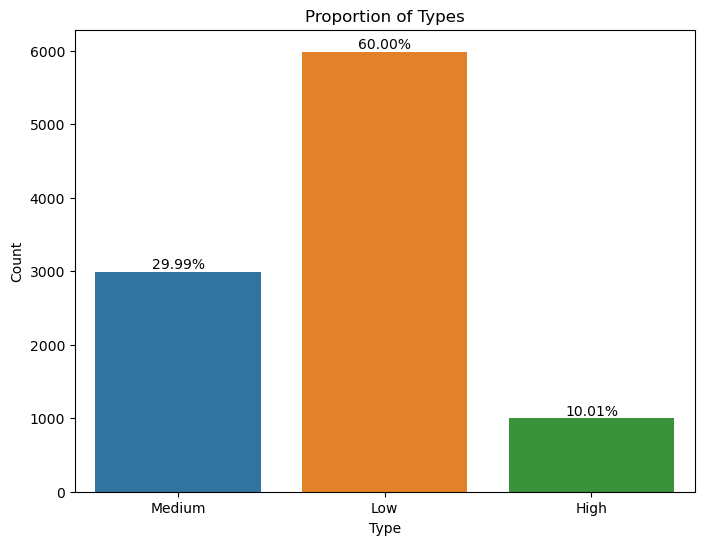

In [1109]:
# Count types
tipo_contagem = df['Type'].value_counts()

# Show graphic
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Type')
plt.title('Proportion of Types')
plt.xlabel('Type')
plt.ylabel('Count')

# Add as percentages as labels
total = len(df['Type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

**It's possible analyse that the "Low" is the majoritary class, "High class is the minority class and "Medium" class have your significance.**

#### **3.8 Plot "Failure_type" distribution**

**We have already analyzed before but we had "Random failure" class. Lets see this updated distribution with a bar graphic to be more clearful see.**

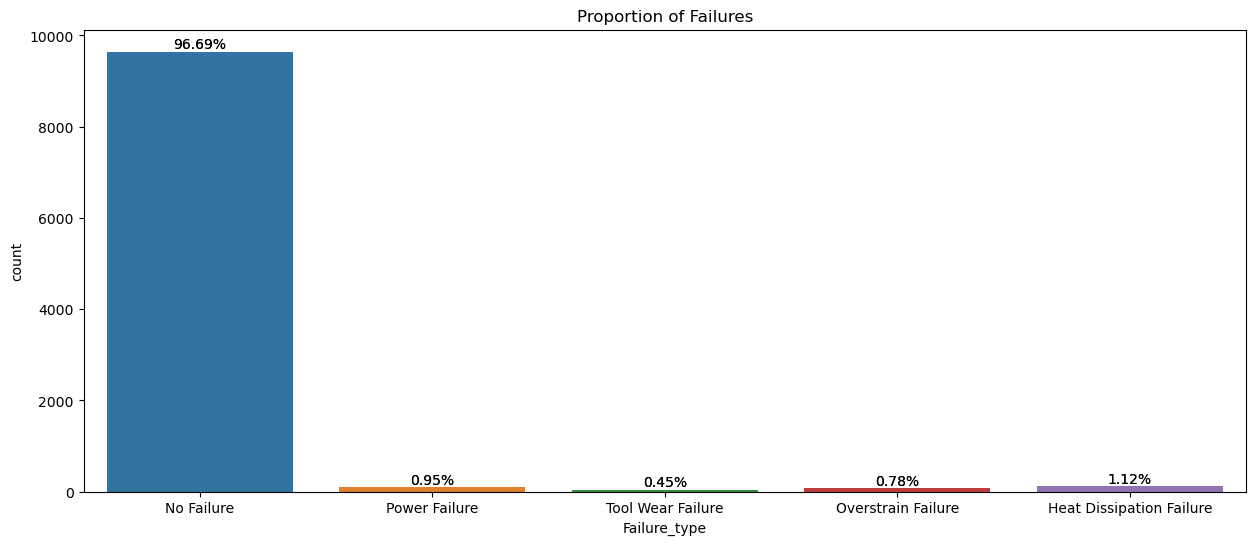

In [1110]:
# Count types
tipo_contagem = df['Failure_type'].value_counts()

# Plot bar graphic
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df, x='Failure_type')
plt.title('Proportion of Failures')
plt.xlabel('Type')
plt.ylabel('Count')

ax = sns.countplot(data=df, x = 'Failure_type')

# Add as percentages as labels
total = len(df['Failure_type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

**As we can see, we have two problems here to model our model. The first is unbalanced classes, we'll need apply some strategic to can biuld a modest model like SMOTE-NC for example. The second is that we'll deal with multiclass problem, it's important always pay attetion is this too.**

#### **3.9 Plot histogram and boxplot with numeric features**

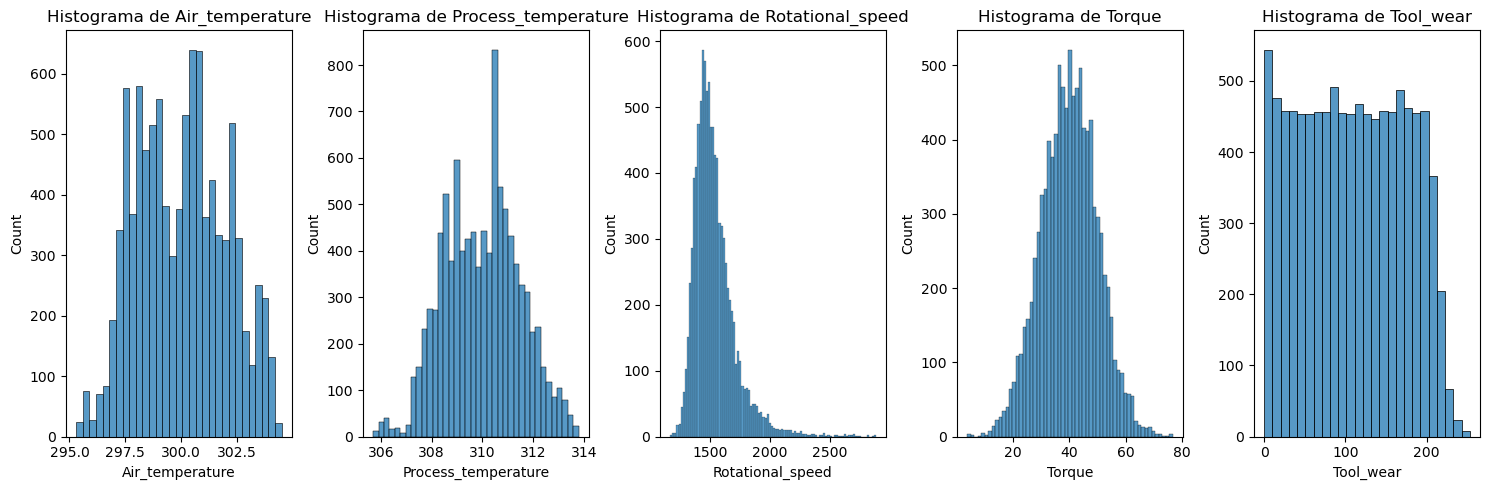

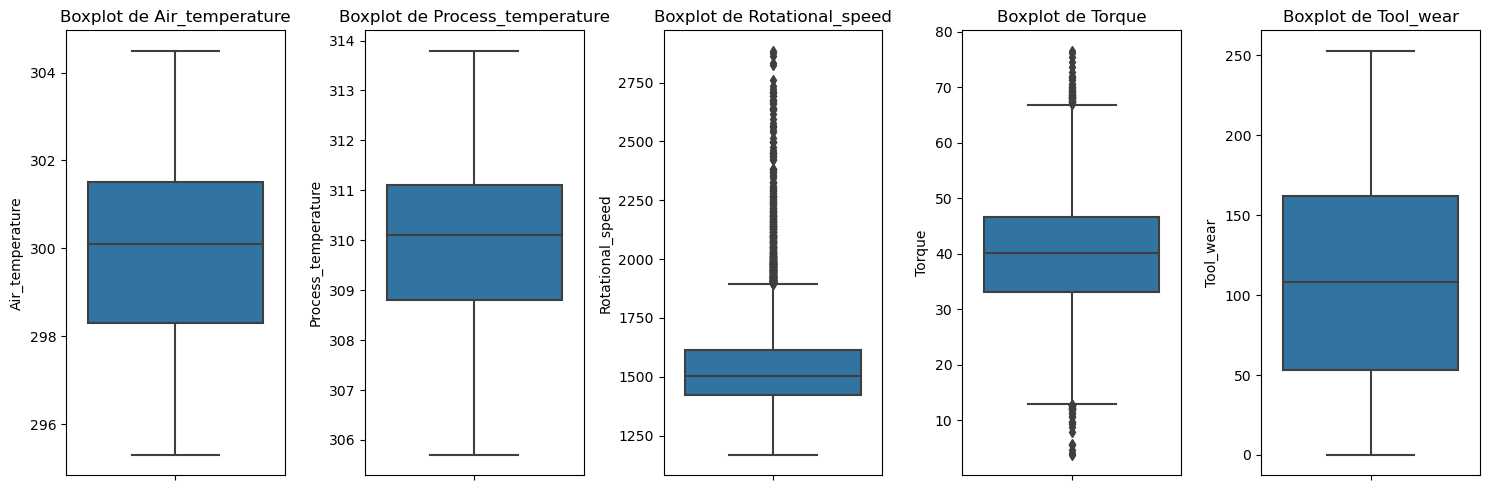

In [1111]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot histograms 
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Histograma de {feature}')

# Adjust subplot 
plt.tight_layout()

# Show histogram 
plt.show()

# Create the figure and axess
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot boxplot side by side
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature}')

# Adjust subplot
plt.tight_layout()

# Show boxplots
plt.show()



**With respect to histogram, the columns Air_temperatura, Process_temperature and torque is similar to normal distribution and  rotation_speed is assimetric with negative bias. Regarding to boxplot, here it's possible confirm the hypothesis that exist outliers is some columns as soon as mencioned in the begging of this project. However, we won't remove this values because make sense that when a machine have one type of failure the values measurement by some sensor will increase so much. Furthermore, when the rotarional_speed increase a lot make totally sense that torque decrease too, this is a physics behavior, so the outliers detected in torque column with low values possibility is caused by this**

#### **3.10 Plot distribution just of failures**

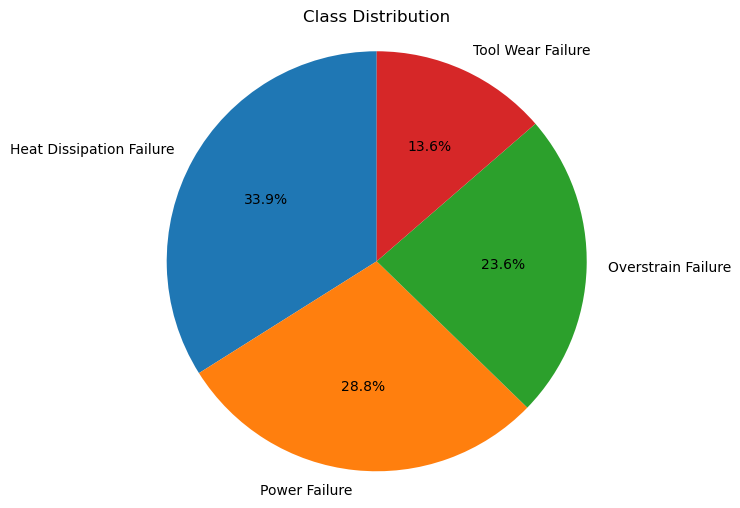

In [1112]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]
# Verifique o balanceamento resultante
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)


# Plotar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Assegura que o gráfico seja desenhado como um círculo
plt.title('Class Distribution')
plt.show()

**There is a small significant portion of the classs "Tool Wear Failure" in compare with the others. This can turn more difficult to the model predict correctly this class without any strategic to try solve this problem. In general, all types of failure is unbalanced in relation to values with "No Failure". Later we will analyse as we can try deal with this to soften this problem.**

#### **3.11 Plot numeric correlation with heatmap**

<Axes: >

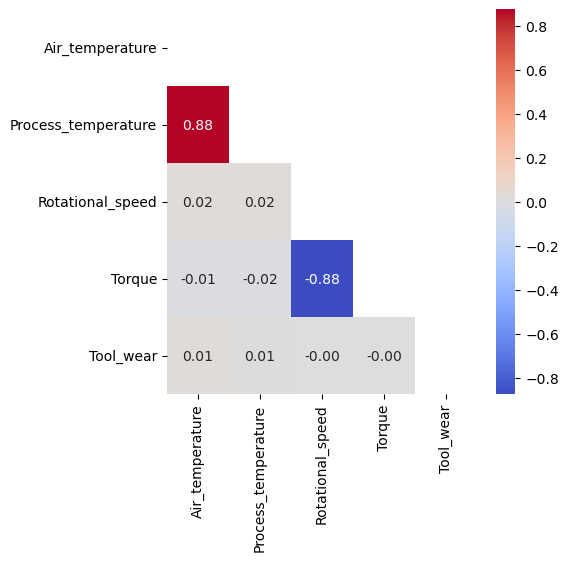

In [1113]:
# Plot correlation of numeric values applying mask
corr = df.corr()
plt.figure(figsize = (5,5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")


**Look how wonderful! Our hypothesis of that when increase torque decrease rotational_speed is true, there is an expressive negative correlation between this features (-0.88). Futhermore, we can see now that process_temperature and air_temperature have an expressive correlation too, when air temeperature increase process temperature increase too, and this happen with the opposite.** 

#### **3.12 Scale numeric features and apply OneHotEncoder for categoric features**

**Scaling numerical features before modeling is essential as it ensures equal contribution of all features, improves algorithm performance, especially for scale-sensitive methods, and enhances model accuracy and training efficiency.Scaling numerical features before modeling is essential as it ensures equal contribution of all features, improves algorithm performance, especially for scale-sensitive methods, and enhances model accuracy and training efficiency.**

In [1114]:
# Create preprocessor ColumnTransformer to do OneHotEncoder for CATEGORIC_FEATURES and StandardScaler() for NUMERIC_FEATURES

# Define the pipelines for numeric and categorical transformations
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, NUMERIC_FEATURES),
    ('cat_trans', cat_pipeline, CATEGORIC_FEATURES)
])

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# Converting the transformed data back to a dataframe for easier visualization
# The transformed data will have new column names, especially for the one hot encoded categories
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES)
new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)

df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)

df_transformed.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0


**I transformed the df_transformed to dataframe to see the changes applied only for curiousity. To realize PCA analysis for example (next step) transform to dataframe is not necessary, we can apply PCA analysis shortly thereafter transform our df.**

#### **3.13 PCA Analysis**

**PCA (Principal Component Analysis) reduces data dimensionality, highlights patterns and simplifies datasets, enhancing model performance and interpretability while preserving essential information. Lets check how much components explain more or less 95% of our data trought the graphic below.**

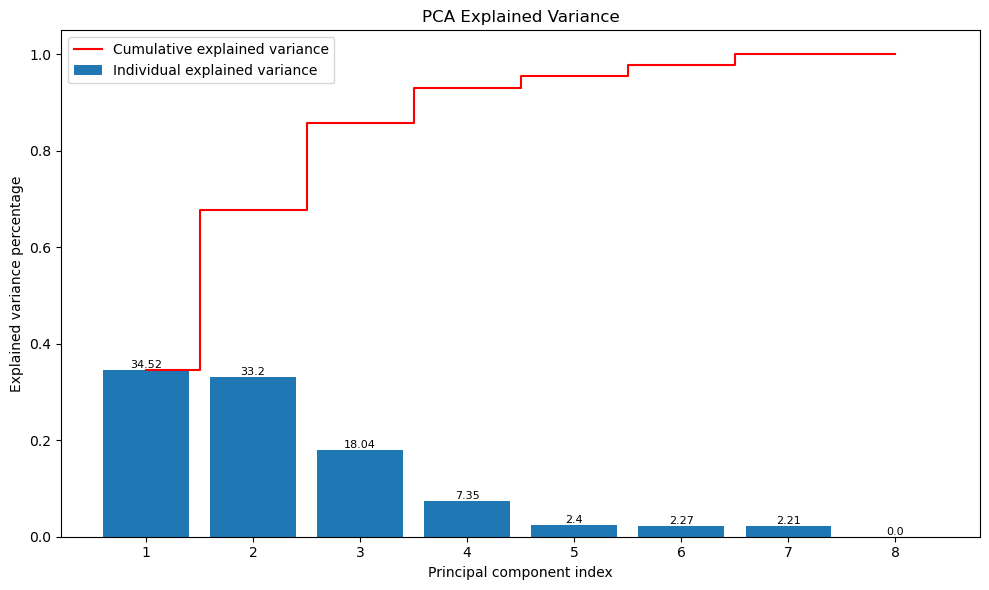

In [1115]:
# Define PCA function
pca = PCA()
pca.fit(df_transformed)  # Assumindo que df_transformed é o seu DataFrame transformado

# PCA variance explained
exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

# Number of components
n_pca_components = len(exp_var)

# Create the graphic
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align='center',
               label='Individual explained variance')
plt.step(range(1, n_pca_components + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Add labels in each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2), 
             va='bottom', ha='center', fontsize=8)

# Adjust others elements of the graphic
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**We can see that with 4 components already explained the variability of our data around 94%. So, we can try use only this components to model and analyse if the perfomance improve. In some cases the dataset can be critic and lost 6% of information can turn the model worst. We'll analyse this in the next steps. Now, lets see what explain each component.**

#### **3.14 Plot explanation of PCA components**

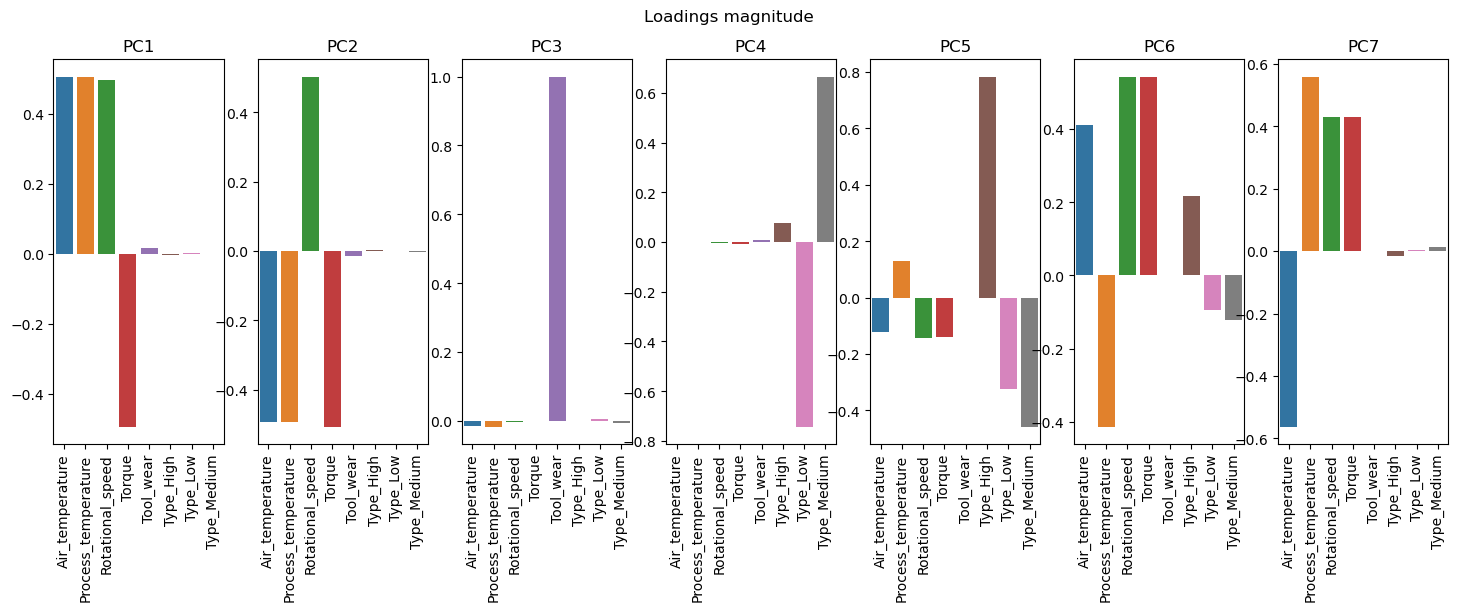

In [1116]:
# PCA with 7 components to analyse what explain each component
pca7 = PCA(n_components=7)
X_pca7 = pd.DataFrame(data=pca7.fit_transform(df_transformed), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7'])

# Configure of the graphics
fig, axs = plt.subplots(ncols=7, figsize=(18,5))
fig.suptitle('Loadings magnitude')


all_features = NUMERIC_FEATURES + list(encoded_feature_names)  # Use encoded_feature_names do 
pca_loadings = pd.DataFrame(data=pca7.components_, columns=all_features)

#Plot the bar graphics
for j in range(7):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))

plt.show()


**As can be observed, see below:
PC1 and PC2: explained by Air_temperature, Process_temperatura, Rotational_speed and Torque;
PC3: explained by Tool_wear;
PC4: most explained by Type_Low and Type_Medium;
PC5: most explained by Type_High;
PC6: most explained by Air_temperature, Process_temperatura, Rotational_speed and Torque;
PC7: most explained by Air_temperature, Process_temperatura, Rotational_speed and Torque.**

# Modeling


In this section, we will test various techniques to address imbalanced classes, as observed in our dataset. We aim to evaluate the performance of models both with and without the use of PCA. Additionally, we will employ SMOTE-NC to manage class imbalance and explore the use of hyperparameters within the model to balance classes without utilizing SMOTE-NC. After determining which approach most effectively enhances model performance, we will proceed to tune the model with GridSearchCV. Beyond developing the best model, this section also tests various techniques, such as building preprocessors and pipelines, to streamline the code and make the modeling process more efficient.

In [1117]:
# Function to show the metrics of model
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro')
    }
    return dict_metrics

It average = 'macro'. When applying this method to calculate metrics, we have a better approach to evaluating the model because this parameter calculates the F1 score for each class individually. If we use "weighted," for instance, the metric is calculated considering the weighted metrics; hence, the majority class has more influence on the result of this metric. In our scenario, the majority class is 'No Failures', and it's easier to simply predict that the machine will not fail. When considering the importance of correctly classifying the types of failures, it's crucial to remember that the model needs to perform well for all classes independently. Therefore, let's examine the model's metrics using average = 'macro'.

In [1166]:
# Now that we knows the number of component that explain our data, lets create a copy of our dataset and build the pipelines.
# Until preparare the pipeline to scale numeric value (StandardScaler/MinMaxScaler for example) and OneHotEncoder for
# the categorical columns and deals with inbalance data, its indispensable separeted the dataset between train and test
# to prevent data leakage.
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

Testing modeling with balancing class with hiper paramters by models. To validate this, we'll consider the metric f1-score

In [1167]:
# Creating pipeline with PCA analysis and balanced class
pip_model_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=4)),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit pipeline with PCA
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_pca.fit(X_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions using the correctly fitted pipeline
y_pred = pip_model_pca.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics


{'Accuracy': 0.8786967418546366,
 'Balanced Accuracy': 0.7085326126948457,
 'Macro Recall': 0.7085326126948457,
 'Macro Precision': 0.3582394621122058,
 'Macro F1': 0.422540112156016}

Critical Information in Dropped Components: The 7% variance not captured by PCA might contain crucial information for your model. This is particularly true for complex datasets where small but important details might be critical for accurate predictions.

Non-linear Relationships: PCA is a linear dimensionality reduction technique. If your data contains non-linear relationships that are important for predictions, PCA might not be able to capture these effectively, leading to a decrease in model performance.

Model-Data Compatibility: Some models are more sensitive to the input feature representation and may perform better with the original features rather than the principal components. This can be due to various reasons, including the type of algorithm, the nature of the data, and the specific task at hand.

Importance of Feature Interactions: If interactions between original features are important for your model, PCA, which creates linear combinations of features, might disrupt these interactions

Is It Problematic?
Not necessarily. It's important to remember that PCA is just one of many tools for dimensionality reduction and feature extraction. If PCA is not improving or is even worsening your model's performance, it's entirely reasonable to choose not to use it.

In [1168]:
# Creating pipeline without PCA analysis and balanced class with parameter by model
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_no_pca.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics


{'Accuracy': 0.9548872180451128,
 'Balanced Accuracy': 0.8193677071112203,
 'Macro Recall': 0.8193677071112203,
 'Macro Precision': 0.5830305073735017,
 'Macro F1': 0.6539249472860765}

In [1169]:
# Get categorical feature indices for SMOTENC
categorical_features_indices = [i for i, feature in enumerate(NUMERIC_FEATURES + CATEGORIC_FEATURES) 
                                if feature in CATEGORIC_FEATURES]

# Creating the new pipeline with SMOTENC using ImbPipeline
pip_model_smotenc = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotenc', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit the pipeline
pip_model_smotenc.fit(X_train, y_train)

# Step 1: Generate Predictions
y_pred = pip_model_smotenc.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics


{'Accuracy': 0.9453634085213033,
 'Balanced Accuracy': 0.8441640973870653,
 'Macro Recall': 0.8441640973870653,
 'Macro Precision': 0.5652665808354431,
 'Macro F1': 0.6459840893394302}

In [1170]:
# Creating pipeline without PCA analysis and balanced class with parameter by model
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier())
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

# Updated parameters for GridSearchCV
params = {
    'model': [
        LogisticRegressionCV(max_iter=500, random_state=2023),
        RandomForestClassifier(random_state=2023),
        GradientBoostingClassifier(random_state=2023),
        DummyClassifier()
    ],
}

# Running GridSearchCV
grid_search = GridSearchCV(pip_model_no_pca, params, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Collecting and printing the results
results = pd.DataFrame(grid_search.cv_results_)
best_model_index = results['mean_test_score'].idxmax()
best_model_params = results.loc[best_model_index, 'params']
best_model_score = results.loc[best_model_index, 'mean_test_score']

#View results
print("Best model:")
print(best_model_params)
print("F1 score of the best model:")
print(best_model_score)



Best model:
{'model': GradientBoostingClassifier(random_state=2023)}
F1 score of the best model:
0.6916351222124032


In [1171]:
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier())
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

#Defining a list of hiper parameters to try tuninning the model
params = {
    'preprocessor__num_trans__num_features': [StandardScaler(), PowerTransformer()],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
}

#Fit GridSearchCV
grid = GridSearchCV(pip_model_no_pca, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

#View results
df_grid_results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
df_grid_results = df_grid_results[['param_model__max_depth', 'param_model__n_estimators', 'mean_test_score', 'std_test_score']]
df_grid_results = df_grid_results.dropna()
df_grid_results = df_grid_results.reset_index(drop=True)
df_grid_results

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
#Finding the best estimator paramaters
tuned_model = grid.best_estimator_
y_pred = tuned_model.predict(X_test)

#View new perfomance (focus on F1-score)
get_metrics(y_test, y_pred)

{'Accuracy': 0.9869674185463659,
 'Balanced Accuracy': 0.6656299220410704,
 'Macro Recall': 0.6656299220410704,
 'Macro Precision': 0.757742200584631,
 'Macro F1': 0.7052986513490196}

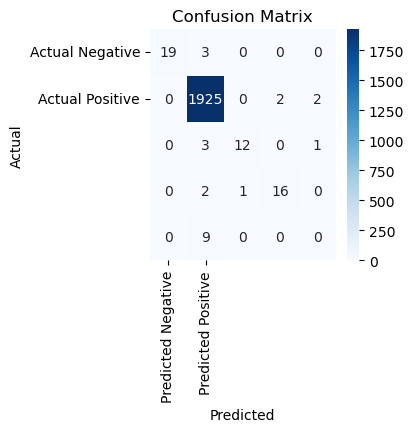

In [1147]:
#Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# Deployment

In [1129]:
with open('../predictive-maintenance/model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)

FileNotFoundError: [Errno 2] No such file or directory: '../predictive-maintenance/model.pkl'

# Conclusion

Predictive maintenance is a strategic approach that aims to anticipate and prevent failures in equipment and machinery, increasing operational efficiency and reducing costs. Within the scope of my data science project, I had the opportunity to explore and apply this methodology through a classification algorithm developed to predict the type of failure in a specific dataset.

The dataset used in this project consists of 10,000 data points, with 14 distinct features, including information such as air temperature, process temperature, rotational speed, torque, tool wear, and a label indicating whether the machine failed or not. Although it was not originally designed for predictive maintenance purposes, I realized that it presented valuable elements for this purpose.

By applying advanced machine learning techniques, I was able to train a classification algorithm capable of predicting the type of failure in a specific process. By utilizing the parameters available in the dataset, such as tool wear, temperature, and torque, the developed model was able to provide insights into the different failure modes that could occur.

This predictive approach enables proactive decision-making regarding maintenance, allowing interventions to be made before a failure occurs. This, in turn, helps to avoid unplanned downtime and reduce costs associated with corrective maintenance.

In summary, the application of predictive maintenance through the classification algorithm developed in this project showcases my knowledge and ability to utilize advanced data science techniques to solve real-world problems. This experience strengthens my portfolio, highlighting my ability to apply data analysis and machine learning to improve operational efficiency and reduce costs in maintenance processes.